## Pytorch Lightning

План:
- `torchmetrics`: пакет с готовыми метриками для любых задач
- `lightning`: фреймворк для описания пайплайнов для обучения моделей на PyTorch
  - `LightningDataModule`: работа с данными
  - `LightningModule`: модель, логика обучения и логирование
  - `Trainer`: управление процессом обучения
  - `Logger`: сохраняем метрики и прочие артефакты для визуализации
  - `Callbacks`: плагины для `Trainer`

In [18]:
import lightning as L
import torch
import torchmetrics
from torch import Tensor, nn
from torch.nn import functional as F

### 1. `torchmetrics`: метрики на все случаи жизни

#### 1.1. Пример: Confusion Matrix

In [19]:
from torchmetrics.classification.confusion_matrix import ConfusionMatrix

# создаём класс, реализующий подсчёт confusion matrix для многоклассовой классификации
num_classes = 10
sample_size = 100
cm = ConfusionMatrix(task="multiclass", num_classes=num_classes)
y_true = torch.randint(10, size=(sample_size,))
# создадим тензор с предсказанными значениями, добавим немного шума
p_error = 0.1
y_pred = torch.where(
    condition=torch.rand(size=(sample_size,)) > p_error,
    input=y_true,
    other=torch.randint(10, size=(sample_size,)),
)
# посчитаем значение метрики
cm_values = cm(y_true, y_pred)
cm_values

tensor([[ 6,  1,  0,  0,  1,  0,  0,  1,  0,  0],
        [ 0, 10,  0,  0,  0,  1,  1,  0,  0,  0],
        [ 0,  0, 12,  0,  0,  0,  0,  0,  1,  1],
        [ 0,  0,  0,  8,  0,  0,  0,  0,  1,  0],
        [ 0,  0,  0,  0,  3,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0, 10,  0,  0,  0,  0],
        [ 0,  1,  0,  0,  0,  0, 12,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0, 12,  0,  0],
        [ 1,  0,  0,  0,  1,  0,  0,  0,  7,  0],
        [ 0,  0,  1,  0,  0,  0,  0,  1,  0,  7]])

Матрицу можно визуализировать, потом мы эту картинку будем сохранять в логи:

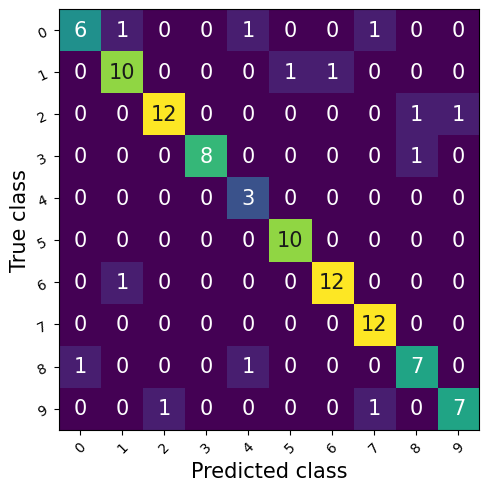

In [20]:
import matplotlib.pyplot as plt

fig, ax = cm.plot()
plt.show()

#### 1.2. Реализуем свою метрику, наследуясь от `torchmetrics.Metric`

In [21]:
class MyAccuracy(torchmetrics.Metric):
    correct: Tensor
    total: Tensor

    def __init__(self) -> None:
        super().__init__()
        self.add_state(name="correct", default=torch.tensor(0), dist_reduce_fx="sum")
        self.add_state(name="total", default=torch.tensor(0), dist_reduce_fx="sum")

    def update(self, preds: Tensor, target: Tensor) -> None:
        # в этот метод приходят предсказания и истинные значения, нам нужно обновить внутреннее состояние
        pred_label = preds.argmax(dim=-1)
        self.correct += (pred_label == target).sum().cpu()
        self.total += target.numel()

    def compute(self) -> Tensor:
        # на основе текущего состояния выводим значение метрики
        return self.correct / self.total if self.total > 0 else torch.tensor(0.0)

In [22]:
# инициализация
acc = MyAccuracy()
# входные данные №1
preds = torch.tensor(
    [
        [0.7, 0.2, 0.1],
        [0.2, 0.8, 0.0],
        [0.2, 0.3, 0.5],
    ]
)
target = torch.tensor([0, 0, 1])

# обновляем состояние и выводим значение
acc.update(preds, target)
print(acc.compute())

# # если хотим - сбрасываем состояние до начального (например, начинается новая эпоха обучения)
# acc.reset()

# # входные данные №2
target = torch.tensor([0, 1, 2])

# # снова обновляем состояние и выводим новое значение
acc.update(preds, target)
print(acc.compute())

tensor(0.3333)
tensor(0.6667)


### 2. Lightning

Мы хотим:
- не писать повторяющийся от проекта к проекту код (boilerplate)
- легко добавлять в цикл обучения новый функционал:
  - расчёт метрик
  - логирование
  - управление сохранением модели
  - распределённое обучение (несколько GPU)
- не менять написанный код без необходимости и управлять экспериментами через удобную конфигурацию

#### 2.1. `LightningDataModule`: все данные в одном месте

Зачем:

Часто очистка / подготовка данных разнесена по разным скриптам, сложно отследить **происхождение данных** и сохранить воспроизводимость, особенно между проектами.

Модуль данных позволяет сохранить информацию:
- откуда берутся данные?
- как они делятся на трейн / тест?
- как происходит семплирование батчей?
- какие преобразования используются?

In [23]:
from typing import Callable

from lightning.pytorch.utilities.types import EVAL_DATALOADERS, TRAIN_DATALOADERS
from PIL.Image import Image
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


class Datamodule(L.LightningDataModule):
    def __init__(
        self,
        batch_size: int,
        transform: Callable[[Image], Tensor] = transforms.ToTensor(),
        num_workers: int = 0,
    ):
        super().__init__()
        self.batch_size = batch_size
        self.transform = transform
        self.num_workers = num_workers

    def prepare_data(self) -> None:
        # в этом методе можно сделать предварительную работу, например
        # скачать данные, сделать тяжёлый препроцессинг
        pass

    def setup(self, stage: str) -> None:
        # аргумент `stage` будет приходить из модуля обучения Trainer
        # на стадии обучения (fit) нам нужны оба датасета
        if stage == "fit":
            self.train_dataset = datasets.CIFAR10(
                "data",
                train=True,
                download=True,
                transform=self.transform,
            )
            self.val_dataset = datasets.CIFAR10(
                "data",
                train=False,
                download=True,
                transform=transforms.ToTensor(),
            )
        # на стадии валидации (validate) - только тестовый
        elif stage == "validate":
            self.val_dataset = datasets.CIFAR10(
                "data",
                train=False,
                download=True,
                transform=self.ToTensor(),
            )
        else:
            raise NotImplementedError
        # есть ещё стадии `test` и `predict`, но они нам не понадобятся

    def train_dataloader(self) -> TRAIN_DATALOADERS:
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
        )

    def val_dataloader(self) -> EVAL_DATALOADERS:
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
        )

In [24]:
datamodule = Datamodule(batch_size=32, num_workers=0)
datamodule.setup(stage="fit")
batch = next(iter(datamodule.train_dataloader()))
for item in batch:
    print(item.shape)

Files already downloaded and verified
Files already downloaded and verified
torch.Size([32, 3, 32, 32])
torch.Size([32])


#### 2.2. `LightningModule`: Описываем модель и её обучение

Идея: обертка над моделью, в которой описан шаг обучения (+ валидации), создание оптимизаторов, логирование метрик. Остальные детали меняются редко, при необходимости их можно переопределить:
- несколько оптимизаторов для разных модулей: GANs, Actor-Critic, 
- более сложная логика оптимизации: обновление генератора чаще, чем дискриминатора
- сделать что-то особенное в начале или конце эпохи (как правило для этого используются `callbacks`)

##### Основные принципы

Модель: нейросетевой блок, объект класса `torch.nn.Module`

Система: набор моделей и их взаимодействие друг с другом согласно определенной логике обучения / валидации: GANs, Seq2Seq, teacher-student

`LightningModule` определяет и модель, и систему.

Он должен быть самодостаточным: могу ли я отправить модуль в `Trainer` (класс для обучения модели, см. ниже), ничего не зная о том, как он устроен?
Оптимизатор привязан к модели, многие модели требуют специальных техник оптимизации.

Обязательные методы:
- `init`
- `training_step`
- `configure_optimizers`

Саму архитектуру модели описываем как раньше, как наследника `torch.nn.Module`:

In [25]:
class ConvBnReluBlock(nn.Module):
    def __init__(
        self, input_dim: int, output_dim: int, kernel_size: int = 3, stride: int = 1
    ) -> None:
        super().__init__()
        self.conv = nn.Conv2d(
            input_dim, output_dim, kernel_size=kernel_size, stride=stride
        )
        self.bn = nn.BatchNorm2d(output_dim)

    def forward(self, x: Tensor) -> Tensor:
        return F.relu(self.bn(self.conv(x)))


class ConvNet(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, output_dim: int) -> None:
        super().__init__()
        self.conv = nn.Sequential(
            ConvBnReluBlock(input_dim, hidden_dim // 4),
            nn.MaxPool2d(2, 2),
            ConvBnReluBlock(hidden_dim // 4, hidden_dim // 2),
            nn.MaxPool2d(2, 2),
            ConvBnReluBlock(hidden_dim // 2, hidden_dim),
            nn.AdaptiveAvgPool2d(1),
        )
        self.fc = nn.Sequential(
            nn.Flatten(1),
            nn.Linear(hidden_dim, output_dim),
        )

    def forward(self, x: Tensor) -> Tensor:
        h = self.conv(x)
        logits = self.fc(h)
        return logits

In [26]:
model = ConvNet(3, 64, 10)
model.forward(batch[0]).shape

torch.Size([32, 10])

Раньше мы писали несколько вспомогательных функций для организации обучения: `training_step`, `test_step`, `run_epoch`. Теперь мы спрячем эту логику внутрь класса `lightning.LightningModule`:

In [27]:
from typing import Any

from lightning.pytorch.utilities.types import STEP_OUTPUT


class Lit(L.LightningModule):
    def __init__(self, model: nn.Module, learning_rate: float) -> None:
        super().__init__()
        self.save_hyperparameters()
        self.model = model
        # TODO: как передать сразу готовый оптимизатор?
        self.learning_rate = learning_rate

    def training_step(
        self, batch: tuple[Tensor, Tensor], batch_idx: int
    ) -> STEP_OUTPUT:

        x, y = batch
        y_hat = self.model(x)
        loss = F.cross_entropy(y_hat, y)
        self.log("train_loss", loss, on_step=False, on_epoch=True)
        # важно: обязательно нужно вернуть значение ошибки либо как тензор первым аргументом,
        # либо в словаре по ключу `loss`
        return loss

    def validation_step(
        self, batch: tuple[Tensor, Tensor], batch_idx: int
    ) -> STEP_OUTPUT | None:
        x, y = batch
        y_hat = self.model(x)
        loss = F.cross_entropy(y_hat, y)
        self.log("val_loss", loss)
        # здесь уже возвращать ничего не нужно, но можно. Позже посмотрим, что и зачем
        return loss

    def configure_optimizers(self) -> dict[str, Any]:
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        # давайте кроме оптимизатора создадим ещё расписание для шага оптимизации
        return {
            "optimizer": optimizer,
            "lr_scheduler": torch.optim.lr_scheduler.MultiStepLR(
                optimizer,
                milestones=[5, 10, 15],
                gamma=0.1,
            ),
        }

Обратите внимание, никаких `torch.no_grad():` или работы с оптимизатором. Оказывается, `lightning` за нас
1. Переключает модель между режимами `train()` и `eval()`
2. Отключает трекинг градиентов на валидации
3. Делает всю работу с градиентами

**Упражнение**: переопределите метод `__init__`, чтобы `LightningModule` принимал частично инициализированный оптимизатор (куда только осталось передать параметры модели) и частично инициализированный `lr_scheduler` (куда останется только передать готовый оптимизатор). После этого внесите правки в метод `configure_optimizers`, чтобы он возвращал указанный при инициализации оптимизатор и расписание

Создадим модуль и выведем информацию о нём:

In [28]:
from lightning.pytorch.callbacks.model_summary import summarize

lit_module = Lit(
    model=ConvNet(input_dim=3, hidden_dim=128, output_dim=10), learning_rate=0.001
)
print(summarize(lit_module, max_depth=2))

  | Name       | Type       | Params | Mode 
--------------------------------------------------
0 | model      | ConvNet    | 95.0 K | train
1 | model.conv | Sequential | 93.7 K | train
2 | model.fc   | Sequential | 1.3 K  | train
--------------------------------------------------
95.0 K    Trainable params
0         Non-trainable params
95.0 K    Total params
0.380     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


/opt/homebrew/anaconda3/envs/dl-mcs/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.


А где же обучение по эпохам?

#### 2.3. `Trainer`: швейцарский нож для управления обучением

Что умеет `Trainer`:

- Итерирование по батчам и эпохам
- Вызовы `optimizer.step()`, `loss.backward()`, `optimizer.zero_grad()`
- Вызов `model.eval()`, включение / выключение градиентов
- Сохранение и загрузка чекпоинтов
- Логирование
- Распределенное обучение на нескольких устройствах
- Mixed precision
- Дополнительная функциональность через `callbacks`

Примеры:

```python
# train on 4 GPUs
trainer = Trainer(
    devices=4,
    accelerator="gpu",
 )

# train 1TB+ parameter models with Deepspeed/fsdp
trainer = Trainer(
    devices=4,
    accelerator="gpu",
    strategy="deepspeed_stage_2",
    precision=16
 )

# 20+ helpful flags for rapid idea iteration
trainer = Trainer(
    max_epochs=10,
    min_epochs=5,
    overfit_batches=1
 )

# access the latest state of the art techniques
trainer = Trainer(callbacks=[StochasticWeightAveraging(...)])
```

In [29]:
from lightning.pytorch.loggers import TensorBoardLogger

trainer = L.Trainer(
    accelerator="auto",
    max_epochs=10,
    limit_train_batches=100,
    limit_val_batches=100,
    logger=TensorBoardLogger(save_dir="."),
)
trainer.fit(
    model=lit_module,
    datamodule=datamodule,
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Files already downloaded and verified
Files already downloaded and verified



  | Name  | Type    | Params | Mode 
------------------------------------------
0 | model | ConvNet | 95.0 K | train
------------------------------------------
95.0 K    Trainable params
0         Non-trainable params
95.0 K    Total params
0.380     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/anaconda3/envs/dl-mcs/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/opt/homebrew/anaconda3/envs/dl-mcs/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Давайте добавим метрики

In [30]:
import torchmetrics.classification


def create_classification_metrics(
    num_classes: int, prefix: str
) -> torchmetrics.MetricCollection:
    return torchmetrics.MetricCollection(
        [
            torchmetrics.Accuracy(task="multiclass", num_classes=num_classes),
            torchmetrics.classification.MulticlassAUROC(
                num_classes=num_classes, average="macro"
            ),
        ],
        prefix=prefix,
    )


class Lit(L.LightningModule):
    def __init__(self, model: nn.Module, learning_rate: float) -> None:
        super().__init__()
        self.save_hyperparameters()
        self.model = model
        self.learning_rate = learning_rate
        self.train_metrics = create_classification_metrics(
            num_classes=10, prefix="train_"
        )
        self.val_metrics = create_classification_metrics(num_classes=10, prefix="val_")

    def training_step(
        self, batch: tuple[Tensor, Tensor], batch_idx: int
    ) -> STEP_OUTPUT:
        x, y = batch
        y_hat = self.model(x)
        loss = F.cross_entropy(y_hat, y)
        # loss теперь сохраняем только раз в эпоху
        self.log("train_loss", loss, on_epoch=True, on_step=False)
        # обновляем метрики и логируем раз в эпоху
        self.train_metrics.update(y_hat, y)
        self.log_dict(self.train_metrics, on_step=False, on_epoch=True)

        return loss

    def validation_step(
        self, batch: tuple[Tensor, Tensor], batch_idx: int
    ) -> STEP_OUTPUT | None:
        x, y = batch
        y_hat = self.model(x)
        loss = F.cross_entropy(y_hat, y)
        self.log("val_loss", loss, on_epoch=True, on_step=False)
        # обновляем метрики и логируем раз в эпоху
        self.val_metrics.update(y_hat, y)
        self.log_dict(self.val_metrics, on_step=False, on_epoch=True)
        # на этот раз вернём предсказания - будем их потом использовать, чтобы отрисовывать confusion matrix

        return {
            "loss": loss,
            "preds": y_hat,
        }

    def configure_optimizers(self) -> dict[str, Any]:
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        # давайте кроме оптимизатора создадим ещё расписание для шага оптимизации
        return {
            "optimizer": optimizer,
            "lr_scheduler": torch.optim.lr_scheduler.MultiStepLR(
                optimizer, milestones=[5, 10, 15]
            ),
        }

In [31]:
trainer = L.Trainer(
    accelerator="auto",
    max_epochs=10,
    limit_train_batches=100,
    limit_val_batches=100,
    logger=TensorBoardLogger(save_dir="."),
)
lit_module = Lit(
    model=ConvNet(input_dim=3, hidden_dim=128, output_dim=10),
    learning_rate=0.01,
)
trainer.fit(
    model=lit_module,
    datamodule=datamodule,
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Files already downloaded and verified
Files already downloaded and verified



  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | ConvNet          | 95.0 K | train
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
-----------------------------------------------------------
95.0 K    Trainable params
0         Non-trainable params
95.0 K    Total params
0.380     Total estimated model params size (MB)
23        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


##### Смотрим на логи обучения

Посмотреть на логи обучения можно, введя в терминале `tensorboard --logdir lightning_logs` и перейдя в браузере по адресу `http://localhost:6006/`. Логи новых экспериментов будут добавляться туда же.

#### 2.4. Callbacks

Самостоятельный компонент, который может быть использован в разных проектах.
Охватывает вспомогательную логику, которая не является обязательной для работы lightning модуля.

```python
from lightning.callbacks import Callback


class MyPrintingCallback(Callback):
    def on_train_start(self, trainer, pl_module):
        print("Training is starting")

    def on_train_end(self, trainer, pl_module):
        print("Training is ending")


trainer = Trainer(callbacks=[MyPrintingCallback()])
```

Давайте реализуем callback для логирования изображения с Confusion Matrix

In [32]:
from typing import cast

from lightning.pytorch.callbacks import Callback
from lightning.pytorch.utilities.types import STEP_OUTPUT
from torchmetrics.classification.confusion_matrix import ConfusionMatrix


class ConfusionMatrixPlotCallback(Callback):
    def __init__(self, class_labels: list[str], normalize: str | None = None) -> None:
        super().__init__()
        self.class_labels = class_labels
        self.confusion_matrix = ConfusionMatrix(
            task="multiclass", num_classes=len(class_labels), normalize=normalize
        )

    def on_validation_batch_end(
        self,
        trainer: L.Trainer,
        pl_module: L.LightningModule,
        outputs: STEP_OUTPUT | None,
        batch: Any,
        batch_idx: int,
        dataloader_idx: int = 0,
    ) -> None:
        _, y = batch
        y_hat = outputs["preds"]
        self.confusion_matrix.update(y_hat.argmax(dim=-1).cpu(), y.cpu())

    def on_validation_epoch_end(
        self, trainer: L.Trainer, pl_module: L.LightningModule
    ) -> None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
        fig, ax = self.confusion_matrix.plot(labels=self.class_labels, ax=ax)
        trainer.logger = cast(TensorBoardLogger, trainer.logger)
        trainer.logger.experiment.add_figure(
            tag="conf-matrix", figure=fig, global_step=trainer.current_epoch
        )
        # writer = SummaryWriter(log_dir=trainer.log_dir)
        # writer.add_figure(tag="conf-matrix", figure=fig, global_step=trainer.current_epoch)
        # writer.close()
        self.confusion_matrix.reset()

Создадим несколько `callbacks`:
- как часто сохранять модель: хранить 2 самых лучших модели по значению ошибки валидации + последнее значение
- сделаем раннюю остановку, если ошибка валидации не снижается последние 5 эпох
- наш `ConfusionMatrixPlotCallback`

In [33]:
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    ModelCheckpoint(
        filename="{epoch}-{val_loss:.2f}",
        monitor="val_loss",
        mode="min",
        save_top_k=2,
        save_last=True,
    ),
    EarlyStopping(
        monitor="val_loss",
        mode="min",
        patience=3,
    ),
    ConfusionMatrixPlotCallback(
        class_labels=trainer.val_dataloaders.dataset.classes,
        normalize="true",
    ),
]

In [34]:
trainer = L.Trainer(
    accelerator="auto",
    max_epochs=10,
    limit_train_batches=100,
    limit_val_batches=100,
    logger=TensorBoardLogger(save_dir="."),
    callbacks=callbacks,
)
lit_module = Lit(
    model=ConvNet(input_dim=3, hidden_dim=128, output_dim=10),
    learning_rate=0.01,
)
trainer.fit(
    model=lit_module,
    datamodule=datamodule,
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Files already downloaded and verified
Files already downloaded and verified



  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | ConvNet          | 95.0 K | train
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
-----------------------------------------------------------
95.0 K    Trainable params
0         Non-trainable params
95.0 K    Total params
0.380     Total estimated model params size (MB)
23        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/anaconda3/envs/dl-mcs/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


#### 2.5. Запуск валидации

In [35]:
from pathlib import Path

# снова используем Trainer, но нам от него теперь понадобится только
# работа с устройством и загрузка чекпоинта
trainer = L.Trainer(accelerator="auto", logger=False)
lit_module = Lit(
    model=ConvNet(input_dim=3, hidden_dim=128, output_dim=10),
    learning_rate=0.01,
)

last_checkpoint_path = Path("lightning_logs/version_2/checkpoints/last.ckpt")
trainer.validate(
    model=lit_module,
    datamodule=datamodule,
    ckpt_path=last_checkpoint_path,
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/anaconda3/envs/dl-mcs/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.


AttributeError: 'Datamodule' object has no attribute 'ToTensor'